In [5]:
import requests
from bs4 import BeautifulSoup
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
import numpy as np


month_dict = {
    "Ocak":1,
    "Şubat":2,
    "Mart":3,
    "Nisan":4,
    "Mayıs":5,
    "Haziran":6,
    "Temmuz":7,
    "Ağustos":8,
    "Eylül":9,
    "Ekim":10,
    "Kasım":11,
    "Aralık":12
}

def get_revision_size_by_month(article):
    url = f'https://tr.wikipedia.org/w/index.php?title={article.replace(" ", "_")}&action=history&limit=3000'

    print(url)
    # Send a GET request
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    #Extract all timestamps
    #timestamps = [item.text for item in soup.find_all('a', class_='mw-changeslist-date')]
    #byte_change = [item.text for item in soup.find_all(class_ = "mw-plusminus-neg mw-diff-bytes")]
    changes = []
    for ul in soup.find_all("ul", class_="mw-contributions-list"):
        bytes_neg = [item.text for item in ul.find_all(class_ = "mw-plusminus-neg mw-diff-bytes")]
        bytes_pos = [item.text for item in ul.find_all(class_ = "mw-plusminus-pos mw-diff-bytes")]
        bytes_all = bytes_neg + bytes_pos
        sum = 0
        for byt in bytes_all:
            byt = byt.replace(".", "")  
            #print({char: ord(char) for char in byt})
            if "+" in byt:
                sum += int(byt[1:].strip())
            elif chr(8722) in byt:
                sum -= int(byt[1:].strip())
            else:
                continue
        try: 
            timestamp = ul.find("a", class_='mw-changeslist-date').text
            date = timestamp.split(' ')[2] + " " + timestamp.split(' ')[3]  
            changes.append({"date": date, "net_change": sum})
        except:
            changes.append({"date": date, "net_change": 0})

    df = pd.DataFrame(changes)
    unique_dates = df['date'].unique()
    grouped_data = df.groupby('date', sort=False)['net_change'].sum()
    new_df = grouped_data.reset_index()
    new_df = new_df.set_index('date').reindex(unique_dates).reset_index()
    reversed_df = new_df.iloc[::-1].reset_index(drop=True)
    return reversed_df


In [274]:
filename1 = os.path.join("data", "politicians", "bakanlar_edited.txt")
filename2 = os.path.join("data", "politicians", "belediye_baskanlari.txt")
filename3 = os.path.join("data", "politicians", "milletvekilleri.txt")
filenames = [filename1, filename2, filename3]
politician_list = list()

for filename in filenames:
    with open(filename, "r") as file:
        politicians = file.readlines()
        for politician in politicians:
            name, party = politician.strip().split(" ")
            politician_list.append({"name": name, "party": party})



In [275]:
def get_wikipedia_article_size_in_bytes(title):
    url = "https://tr.wikipedia.org/w/api.php"
    params = {
        'action': 'query',
        'format': 'json',
        'titles': title,
        'prop': 'info',
        'inprop': 'url|size'
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    pages = data.get('query', {}).get('pages', {})
    if pages:
        # Get the first page object
        page = next(iter(pages.values()))
        size = page.get('length', 'No size information found')
        return size
    else:
        return "Article not found."

# Example usage
title = "Meral_Akşener"
print(get_wikipedia_article_size_in_bytes(title))


47973


In [276]:
""" for i, politician in enumerate(politician_list):
    article = politician["name"]
    size = get_wikipedia_article_size_in_bytes(article)
    politician["article_size"] = size
 """

' for i, politician in enumerate(politician_list):\n    article = politician["name"]\n    size = get_wikipedia_article_size_in_bytes(article)\n    politician["article_size"] = size\n '

In [277]:
aksener = {"name": "Meral_Akşener", "party": "iyi_parti", "article_size": get_wikipedia_article_size_in_bytes("Meral_Akşener")}
babacan = {"name": "Ali_Babacan", "party": "deva_partisi", "article_size": get_wikipedia_article_size_in_bytes("Ali_Babacan")}
davutoglu = {"name": "Ahmet_Davutoğlu", "party": "gelecek_partisi", "article_size": get_wikipedia_article_size_in_bytes("Ahmet_Davutoğlu")}
politician_list = politician_list + [aksener, babacan, davutoglu]

In [278]:
filename = os.path.join("data", "politicians", "politicians_sizes.csv")
politicians_sizes = pd.DataFrame(politician_list)
politicians_sizes["article_size"] = politicians_sizes["article_size"].replace("No size information found", "N/A") 
politicians_sizes.to_csv(filename, index=False)


#### prepare edit dataframe by month


In [279]:
months = list(month_dict.keys())
years = [str(year) for year in range(2013, 2025)]
dates = [month + " " + year for year in years for month in months]
columns = ["name", "party", "article_size"] + dates
filename = os.path.join("data", "politicians", "top100.csv")
politicians_100 = pd.read_csv(filename).drop("Unnamed: 0", axis=1)
edit_history = pd.DataFrame(columns=columns)


In [280]:
# returns a list of net change value for a given politician
def get_net_change_list(df):
    values = []
    for date in dates:
        idx = (df["date"] == date)
        if (~idx).all():
            values.append(0)
        else:
            net_change_value = df.loc[idx, "net_change"].item()
            values.append(net_change_value)
    return values


In [281]:
""" for index in politicians_100.index:
    name, party, article_size = politicians_100.loc[index, ["name", "party", "article_size"]]
    data = get_revision_size_by_month(name)
    values = get_net_change_list(data)
    row = [name, party, article_size] + values
    edit_history.loc[index] = row
     """

' for index in politicians_100.index:\n    name, party, article_size = politicians_100.loc[index, ["name", "party", "article_size"]]\n    data = get_revision_size_by_month(name)\n    values = get_net_change_list(data)\n    row = [name, party, article_size] + values\n    edit_history.loc[index] = row\n     '

In [6]:
filefolder = os.path.join("data", "politicians")
filename = os.path.join(filefolder, "edit_history.csv")
#edit_history.to_csv(filename, index=False)

In [7]:
edit_history = pd.read_csv(filename)

In [284]:
def plot_article_edit_freq(article_name):
    # Filter the DataFrame to find rows where the 'name' column matches 'article_name'
    idx = edit_history["name"] == article_name
    article_data = edit_history[idx]
    
    # Extract column names for dates (assuming these start from the 4th column)
    cols = edit_history.columns[3:]
    dates = np.array(cols)
    
    # Assuming 'article_data' contains only one row of data for the specified article
    if not article_data.empty:
        values = article_data.loc[:, cols].values.flatten()
        
        fig = plt.figure(figsize=(12, 5))
        plt.plot(dates, values)  
        plt.title(article_name)  
        tick_positions = np.arange(len(dates))  # Positions of all ticks
        tick_labels = [date if i % 3 == 0 else '' for i, date in enumerate(dates)]  # Labels every 5 ticks
        plt.xticks(tick_positions, tick_labels, rotation='vertical', fontsize=6)
        plt.tight_layout()
        plt.show()
    else:
        print("No data found for article:", article_name)


In [285]:
edit_history["party"].unique()

array(['adalet_ve_kalkınma_partisi', 'cumhuriyet_halk_partisi',
       'milliyetçi_hareket_partisi', 'deva_partisi', 'iyi_parti',
       'gelecek_partisi', 'zafer_partisi', 'türkiye_i̇şçi_partisi',
       'bağımsız', 'halkların_demokratik_partisi', 'i̇yi̇_parti',
       'halkların_eşitlik_ve_demokrasi_partisi', 'demokrat_parti',
       'yenilik_partisi'], dtype=object)

In [330]:
idx = edit_history["party"] == "milliyetçi_hareket_partisi"
edit_history[idx].loc[:, ["name", "Nisan 2016"]]


,name,Nisan 2016
3,Devlet_Bahçeli,120
15,Saffet_Sancaklı,0
84,Olcay_Kılavuz,0


In [332]:
edit_history["Haziran 2016"]

0     20864
1      3552
2     30310
3      9928
4       303
      ...  
95        0
96        0
97      177
98        0
99        0
Name: Haziran 2016, Length: 100, dtype: int64

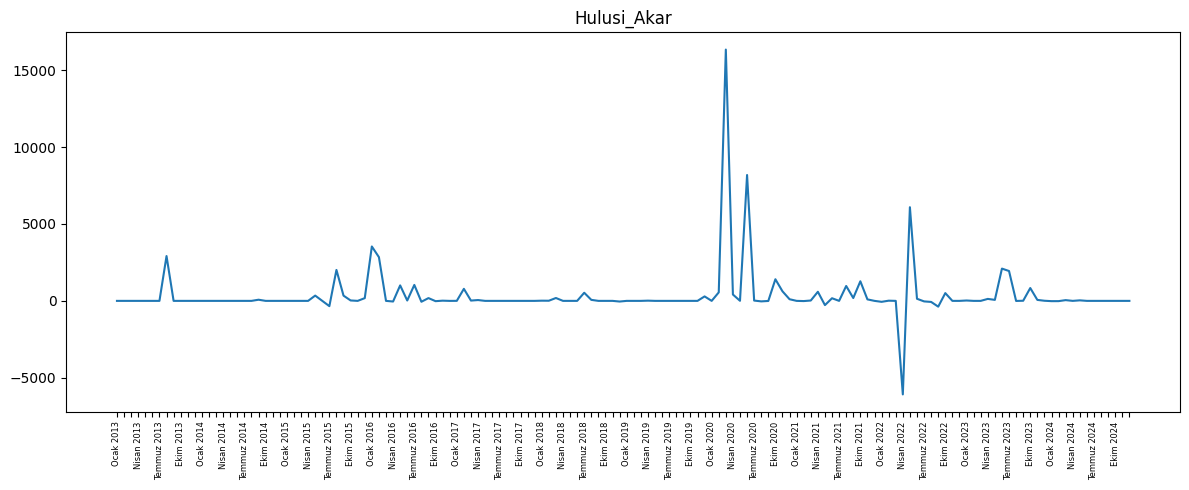

In [291]:
plot_article_edit_freq("Meral_Akşener")

In [333]:
df = edit_history[edit_history["party"] == "milliyetçi_hareket_partisi"]
df.loc[:, "Ocak 2013": "Aralık 2024"].abs().sum().sort_values(ascending=False)

Temmuz 2016     28385
Ekim 2021       22006
Mayıs 2021      18112
Haziran 2016    10839
Mart 2023        6888
                ...  
Aralık 2019         0
Şubat 2020          0
Temmuz 2021         0
Eylül 2021          0
Aralık 2024         0
Length: 144, dtype: int64

In [347]:
date1 = "Haziran 2016"
date2 = "Temmuz 2016"
date3 = "Mayıs 2016"
df = edit_history[["name", "party", date1, date2, date3]]
df["sum"] = df[date1] + df[date2] +df[date3]
#edit_history[["name", "party", "Haziran 2016", "Temmuz 2016"]].sort_values(["Haziran 2016"], ascending=False).head(7)
df

/var/folders/7r/jxgv86_s37710lr8nq321dxh0000gn/T/ipykernel_80656/241505362.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sum"] = df[date1] + df[date2] +df[date3]


,name,party,Haziran 2016,Temmuz 2016,Mayıs 2016,sum
0,Recep_Tayyip_Erdoğan,adalet_ve_kalkınma_partisi,20864,15000,5820,41684
1,Kemal_Kılıçdaroğlu,cumhuriyet_halk_partisi,3552,1001,47,4600
2,Binali_Yıldırım,adalet_ve_kalkınma_partisi,30310,-3950,7086,33446
3,Devlet_Bahçeli,milliyetçi_hareket_partisi,9928,28385,7,38320
4,Ali_Babacan,deva_partisi,303,0,-12,291
...,...,...,...,...,...,...
95,Mustafa_Savaş,adalet_ve_kalkınma_partisi,0,-14,5686,5672
96,Lütfü_Türkkan,i̇yi̇_parti,0,0,0,0
97,Selin_Sayek_Böke,cumhuriyet_halk_partisi,177,-4,-42,131
98,Mehmet_Fatih_Kacır,bağımsız,0,0,0,0


In [38]:
date1 = "Ocak 2020"
date2 = "Şubat 2020"
date3 = "Mart 2020"
df = edit_history[["name", "party", date1, date2, date3]]
df["sum"] = df[date1] + df[date2] +df[date3]
#edit_history[["name", "party", "Haziran 2016", "Temmuz 2016"]].sort_values(["Haziran 2016"], ascending=False).head(7)
df = df.sort_values("sum", ascending=False).head(10)

df.to_csv("data/politicians/Top10_Ocak2020.csv")

/var/folders/7r/jxgv86_s37710lr8nq321dxh0000gn/T/ipykernel_92117/3645244673.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sum"] = df[date1] + df[date2] +df[date3]


In [39]:
df = df.sort_values(["sum"], ascending=False).head(7)
#df.to_csv("data/politicians/top7_temmuz2016.csv")

In [31]:
column_names = ["name"] + list(edit_history.loc[:, "Haziran 2023": "Ocak 2024"].columns)
selected_columns = edit_history[column_names]
idx = selected_columns["name"].isin(["Kemal_Kılıçdaroğlu", "Ekrem_İmamoğlu", "Recep_Tayyip_Erdoğan"])
selected_columns[idx]

,name,Haziran 2023,Temmuz 2023,Ağustos 2023,Eylül 2023,Ekim 2023,Kasım 2023,Aralık 2023,Ocak 2024
0,Recep_Tayyip_Erdoğan,8014,1012,-2254,-51777,-1427,620,-134,-47
1,Kemal_Kılıçdaroğlu,-1213,547,-1,-462,537,256,829,612
5,Ekrem_İmamoğlu,344,462,-5,190,3915,129,21,271
